In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate


from sklearn.tree import DecisionTreeClassifier 

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier





In [2]:
features_df = pd.read_csv('Data/training_set_features.csv', index_col="respondent_id")
labels_df = pd.read_csv('Data/training_set_labels.csv', index_col="respondent_id")
joined_df = features_df.join(labels_df, how = 'inner')

In [3]:
# an all-in-one data cleaning function. Do this BEFORE OHE
# Maybe this should be a class and worked into the pipeline?
def datacleaner(maindataframe):
    #For dropping whole columns 
    def columndrop(dataframe, column_list):
        dataframe.drop(column_list, axis = 1, inplace=True)
    #For dropping rows with na values
    def basicdropna(dataframe, column_list):
        dataframe.dropna(subset=column_list, inplace=True)
    #For special case imputation
    def impute_missing_data(dataframe, column_list, fillvalue):
        for column in column_list:
            dataframe[column].fillna(fillvalue, inplace = True)
    #This creates a number of lists of columns that fall into a few different 
    #categories, that will be processed in different ways. See notes below on how
    #these choices were made.
    drop_columns =  ['employment_industry',  'employment_occupation', 'hhs_geo_region']       
        
    general_dropna = ['health_worker', 'education','income_poverty', 'marital_status', 
                    'rent_or_own', 'employment_status', 'household_adults', 
                    'household_children' ]
        
    survey_col = ['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
         'opinion_seas_vacc_effective', 'opinion_seas_risk','opinion_seas_sick_from_vacc']

    behavior_col = ['behavioral_antiviral_meds', 'behavioral_face_mask',
                'behavioral_large_gatherings','behavioral_outside_home']

    behavior_col_2 = ['behavioral_avoidance', 
                'behavioral_wash_hands','behavioral_touch_face']

    doc_rec = ['doctor_recc_h1n1','doctor_recc_seasonal']
    
    basicdropna(maindataframe, general_dropna)
    columndrop(maindataframe, drop_columns)
    impute_missing_data(maindataframe, survey_col, 3)
    impute_missing_data(maindataframe, ['h1n1_concern'], 2)
    impute_missing_data(maindataframe, ['h1n1_knowledge'], 0)
    impute_missing_data(maindataframe, behavior_col, 0)
    impute_missing_data(maindataframe, behavior_col_2, 1)
    impute_missing_data(maindataframe, doc_rec, 0)
    impute_missing_data(maindataframe, ['chronic_med_condition'], 0)
    impute_missing_data(maindataframe, ['child_under_6_months'], 0)


In [4]:
datacleaner(joined_df)

In [5]:
X=joined_df.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
y=joined_df[['h1n1_vaccine','seasonal_vaccine']]

# Train test split, do this before OHE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# create OHE for objects, do this before imputer

cat_col_list = [i for i in X_train.select_dtypes(include='object').columns]

nb_list_for_ohe = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

# Fits OHE on a subset of columns, then reintegrates them into the
# Origional dataframe. Do this after initial cleaning, before 
# health insurace imputation.

ohe = OneHotEncoder(drop='first', sparse=False)

def fit_trans_ohe(X_dataframe, columns):
        
    dums = ohe.fit_transform(X_dataframe[columns])
    dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_dataframe.index)
    df_cat_dropped = X_dataframe.drop(cat_col_list, axis = 1)
    dums_df_concated = pd.concat([df_cat_dropped, dums_df], axis=1)
    return dums_df_concated

#We should end up with a fitted ohe instance called 'ohe'

In [7]:
X_train_ohe = fit_trans_ohe(X_train, cat_col_list+nb_list_for_ohe)

In [8]:
    
socio_economic_column_list = ["x0_35 - 44 Years","x0_45 - 54 Years","x0_55 - 64 Years","x0_65+ Years",
                              "x1_< 12 Years","x1_College Graduate","x1_Some College","x2_Hispanic",
                              "x2_Other or Multiple","x2_White","x3_Male", "x4_> $75,000", "x4_Below Poverty",
                              "x5_Not Married", "x6_Rent", "x7_Not in Labor Force","x7_Unemployed",
                              "x8_MSA, Principle City",'x8_Non-MSA', 'health_insurance']

# Fitting an imputer for Health Insurance using socio-economic features, 
# pulling from a dataframe that has already been OneHotEncoded


soc_eco_h_i_imputer_knn = KNNImputer()

def soc_eco_KNN_imputer(imputer, dataframe, column_list):
    soc_econ_base = dataframe[column_list]
    soc_econ_imputed = pd.DataFrame(imputer.fit_transform(soc_econ_base), 
                                         columns = soc_econ_base.columns,
                                        index=soc_econ_base.index)
    remainder_df = dataframe.drop(column_list, axis = 1)
    output_df = remainder_df.join(soc_econ_imputed)
    output_df.health_insurance = output_df.health_insurance.round() 

    return output_df


In [9]:
X_train_imputed = soc_eco_KNN_imputer(soc_eco_h_i_imputer_knn, X_train_ohe, socio_economic_column_list)

In [10]:
# The OHE for the test set only, takes X test dataframe and list of columns to encoded:
def trans_ohe(X_dataframe, columns):
    dums = ohe.transform(X_dataframe[columns])
    dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_dataframe.index)
    df_cat_dropped = X_dataframe.drop(cat_col_list, axis = 1)
    dums_df_concated = pd.concat([df_cat_dropped, dums_df], axis=1)
    return dums_df_concated

In [11]:
X_test_ohe = trans_ohe(X_test, cat_col_list+nb_list_for_ohe)

In [12]:
def imputer_transform_only(imputer, dataframe, column_list):
    soc_econ_base = dataframe[column_list]
    soc_econ_imputed = pd.DataFrame(imputer.transform(soc_econ_base), 
                                         columns = soc_econ_base.columns,
                                        index=soc_econ_base.index)
    remainder_df = dataframe.drop(column_list, axis = 1)
    output_df = remainder_df.join(soc_econ_imputed)
    output_df.health_insurance = output_df.health_insurance.round()
    
    return output_df

In [13]:
X_test_imputed = imputer_transform_only(soc_eco_h_i_imputer_knn, X_test_ohe, socio_economic_column_list)

### We now have a working dataset of: 
    'X_train_imputed' and 'y_train' to fit models to, 'X_test_ohe' to generate predictions, and 'y_test' to validate models with.

### Baseline Model

In [14]:
y_train.h1n1_vaccine.value_counts(normalize=True) # =>Change to DummyClassifier  

0    0.783521
1    0.216479
Name: h1n1_vaccine, dtype: float64

In [15]:
y_train.seasonal_vaccine.value_counts(normalize=True)  # =>Change to DummyClassifier  

0    0.531887
1    0.468113
Name: seasonal_vaccine, dtype: float64

### Decision Tree Classifier

In [16]:

# HlN1 

dt_f = DecisionTreeClassifier(criterion='entropy', splitter='random')

dt_f.fit(X_train_imputed, y_train.h1n1_vaccine)

h1n1_dt = cross_val_score(dt_f, X_train_imputed, y_train['h1n1_vaccine'], scoring='roc_auc', cv=5).mean()

#Seasonal Flu

dt_sea = DecisionTreeClassifier(criterion='entropy', splitter='random')

dt_sea.fit(X_train_imputed, y_train.seasonal_vaccine)

sea_dt = cross_val_score(dt_sea, X_train_imputed, y_train['seasonal_vaccine'], scoring='roc_auc', cv=5).mean()

print(f'Decision Tree, H1N1, cv ROC_AUC score:{h1n1_dt}')
print(f'Decision Tree, Seasonal, cv ROC_AUC score:{sea_dt}')



Decision Tree, H1N1, cv ROC_AUC score:0.6529785520947285
Decision Tree, Seasonal, cv ROC_AUC score:0.6866174708375896


### KNN

In [17]:
# HlN1 

knn_f_h1 = KNeighborsClassifier(n_neighbors=19, metric='manhattan')
knn_f_h1.fit(X_train_imputed, y_train.h1n1_vaccine)

h1n1_knn = cross_val_score(knn_f_h1, X_train_imputed, y_train['h1n1_vaccine'], scoring='roc_auc', cv=5).mean()

# Seasonal Flu 

knn_f_s = KNeighborsClassifier(n_neighbors=27, metric='manhattan')
knn_f_s.fit(X_train_imputed, y_train.seasonal_vaccine)

sea_knn = cross_val_score(knn_f_s, X_train_imputed, y_train['seasonal_vaccine'], scoring='roc_auc', cv=5).mean()


print(f'KNN, H1N1, cv ROC_AUC score:{h1n1_knn}')
print(f'KNN, Seasonal, cv ROC_AUC score:{sea_knn}')




KNN, H1N1, cv ROC_AUC score:0.7925370064623928
KNN, Seasonal, cv ROC_AUC score:0.8282253347105135


### Logistic Regression

In [18]:

# H1N1 
# {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000000, 'penalty': 'l1', 'solver': 'saga'}


log_f_h1=LogisticRegression(C=1,penalty="l1", class_weight='balanced', max_iter=1000000,
                              solver='saga')

log_f_h1.fit(X_train_imputed, y_train.h1n1_vaccine)

h1n1_log = cross_val_score(estimator=log_f_h1, X=X_train_imputed, y=y_train.h1n1_vaccine, 
                cv=5, scoring='roc_auc').mean() 

# Seasonal 
#{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}


log_f_s=LogisticRegression(C=1,penalty="l1", class_weight='balanced', max_iter=10000,
                              solver='saga')
log_f_s.fit(X_train_imputed, y_train.h1n1_vaccine)

sea_log = cross_val_score(estimator=log_f_s, X=X_train_imputed, y=y_train.seasonal_vaccine, 
                cv=5, scoring='roc_auc').mean() 


print(f'Logistic, H1N1, cv ROC_AUC score:{h1n1_log}')
print(f'Logistic, Seasonal, cv ROC_AUC score:{sea_log}')


Logistic, H1N1, cv ROC_AUC score:0.8396362829929555
Logistic, Seasonal, cv ROC_AUC score:0.8564573211066776


### GradientBoostingClassifier

In [19]:
# H1N1 

gbc_f_h1 = GradientBoostingClassifier(loss= 'exponential', learning_rate= .05, random_state = 14,
                                                max_depth=3, max_features='log2', n_estimators=700)

gbc_f_h1.fit(X_train_imputed, y_train['h1n1_vaccine'])

h1n1_gbc = cross_val_score(gbc_f_h1, X_train_imputed, y_train['h1n1_vaccine'], scoring='roc_auc')



In [20]:
# Seasonal Flu

gbc_f_s = GradientBoostingClassifier(loss= 'exponential', learning_rate= .05, random_state = 14,
                                                max_depth=3, max_features='log2', n_estimators=700)

gbc_f_s.fit(X_train_imputed, y_train['seasonal_vaccine'])

sea_gbc = cross_val_score(gbc_f_s, X_train_imputed, y_train['seasonal_vaccine'], scoring='roc_auc')

print(f'Logistic, H1N1, cv ROC_AUC score:{h1n1_gbc}')
print(f'Logistic, Seasonal, cv ROC_AUC score:{sea_gbc}')


Logistic, H1N1, cv ROC_AUC score:[0.83926775 0.8413195  0.85579801 0.82667306 0.84817786]
Logistic, Seasonal, cv ROC_AUC score:[0.86101862 0.85841588 0.85376613 0.86606036 0.85903635]


### ROC curve

#### H1N1

In [21]:
# Get predicted probability 

# DT
y_pred_h1_dt = dt_f.predict_proba(X_test_imputed)[:, 1] #=> Error 

# KNN

y_pred_h1_knn = knn_f_h1.predict_proba(X_test_imputed)[:, 1] 

# Log
y_pred_h1_log = log_f_h1.predict_proba(X_test_imputed)[:, 1]

# GBC 

y_pred_h1_gbc = gbc_f_h1.predict_proba(X_test_imputed)[:, 1]


In [27]:
# Get the FPR and TPR data

# DT
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test.h1n1_vaccine, y_pred_h1_dt)

# KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test.h1n1_vaccine, y_pred_h1_knn)

# Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_test.h1n1_vaccine, y_pred_h1_log)

# GBC 
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test.h1n1_vaccine, y_pred_h1_gbc)



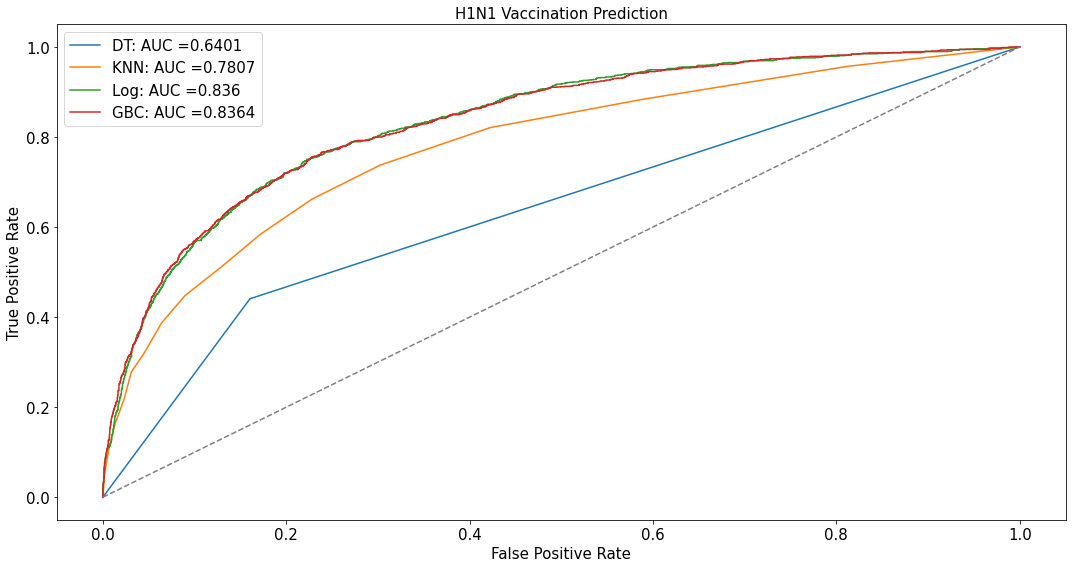

In [28]:

# Plot the FPR and TPR data

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(fpr_dt, tpr_dt, alpha =1, 
        label=f'DT: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_dt),4)}')

ax.plot(fpr_knn, tpr_knn, alpha =1, 
        label=f'KNN: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_knn),4)}')


ax.plot(fpr_log, tpr_log, alpha =1, 
        label=f'Log: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_log),4)}')

ax.plot(fpr_gbc, tpr_gbc, alpha=1,
       label=f'GBC: AUC ={round(roc_auc_score(y_test.h1n1_vaccine, y_pred_h1_gbc),4)}')

ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('H1N1 Vaccination Prediction', fontsize=15)
    
ax.legend(fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

#### Seasonal Flu

In [30]:
# Get predicted probability 

# DT
y_pred_s_dt = dt_sea.predict_proba(X_test_imputed)[:, 1]

# KNN

y_pred_s_knn = knn_f_s.predict_proba(X_test_imputed)[:, 1]

# Log
y_pred_s_log = log_f_s.predict_proba(X_test_imputed)[:, 1]

# GBC 

y_pred_s_gbc = gbc_f_s.predict_proba(X_test_imputed)[:, 1]


In [31]:
# Get the FPR and TPR data

# DT
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test.seasonal_vaccine, y_pred_s_dt)

# KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test.seasonal_vaccine, y_pred_s_knn)

# Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_test.seasonal_vaccine, y_pred_s_log)

# GBC 
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test.seasonal_vaccine, y_pred_s_gbc)



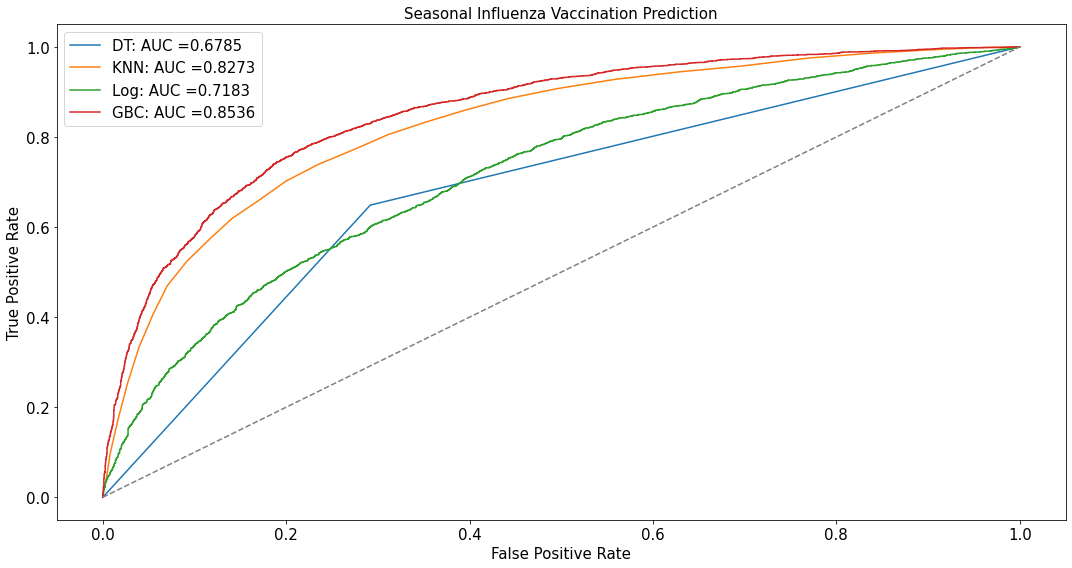

In [32]:

# Plot the FPR and TPR data

fig, ax = plt.subplots(figsize=(15, 8))


ax.plot(fpr_dt, tpr_dt, alpha =1, 
        label=f'DT: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_dt),4)}')

ax.plot(fpr_knn, tpr_knn, alpha =1, 
        label=f'KNN: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_knn),4)}')

ax.plot(fpr_log, tpr_log, alpha =1, 
        label=f'Log: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_log),4)}')

ax.plot(fpr_gbc, tpr_gbc, alpha=1,
       label=f'GBC: AUC ={round(roc_auc_score(y_test.seasonal_vaccine, y_pred_s_gbc),4)}')

ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('Seasonal Influenza Vaccination Prediction', fontsize=15)
    
ax.legend(fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();